In [1]:
from scipy import sparse, stats
import pandas as pd
import numpy as np
import sys

In [2]:
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1

In [3]:
import dask.dataframe as dd
import scipy.io
import csv
import gzip
import os

cb_file='/home/bxj139/ASE/NA12878.qc'

cb_stat = pd.read_csv(cb_file,header=0)
cb_keep = cb_stat.loc[cb_stat['keep']==1,'cb']

Text(0.5, 0, '# UMI')

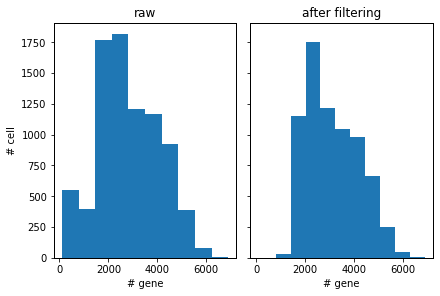

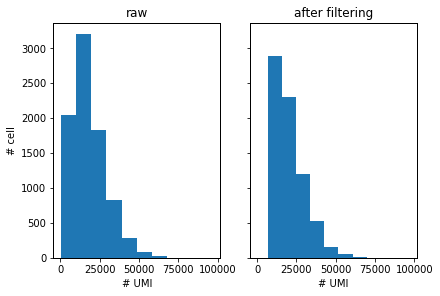

In [4]:
fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
ax[0].set_ylabel('# cell')
ax[0].hist(cb_stat['num_gene'])
ax[0].set_title('raw')
ax[0].set_xlabel('# gene')
ax[1].hist(cb_stat.loc[cb_stat['keep']==1,'num_gene'])
ax[1].set_title('after filtering')
ax[1].set_xlabel('# gene')

fig,ax = plt.subplots(ncols=2, sharex=True, sharey=True, constrained_layout=True)
ax[0].set_ylabel('# cell')
ax[0].hist(cb_stat['num_umi'])
ax[0].set_title('raw')
ax[0].set_xlabel('# UMI')
ax[1].hist(cb_stat.loc[cb_stat['keep']==1,'num_umi'])
ax[1].set_title('after filtering')
ax[1].set_xlabel('# UMI')

In [5]:
import warnings
warnings.filterwarnings('ignore')
from lib.ase_bn import *
umi_file='/home/bxj139/ASE/test.mtx'
ase_file='/home/bxj139/ASE/test.ase'

umi_raw = pd.read_csv(umi_file)
ase_raw = pd.read_csv(ase_file)

# filtered cells
cb_keep = cb_stat.loc[cb_stat['keep']==1]
umi = pd.merge(umi_raw, cb_keep, on='cb')
ase = pd.merge(ase_raw, cb_keep, on='cb')

ase_infer_outfile1 = '/home/bxj139/ASE/test_thres1.ase'
allele_infer(umi,ase,ase_infer_outfile1)
print(len(ase))

ase_infer_outfile2 = '/home/bxj139/ASE/test_thres2.ase'
min_reads=2
ase_filter = ase.loc[(ase['ub_maternal']>=min_reads) | (ase['ub_paternal']>=min_reads)]
allele_infer(umi,ase_filter,ase_infer_outfile2)
print(len(ase_filter))

520
66


In [6]:
ase_infer = pd.read_csv(ase_infer_outfile1+'.infer',header=0)
ase_infer_stat = pd.read_csv(ase_infer_outfile1+'.record',header=0)
ase_infer.head(5)

ase_infer2 = pd.read_csv(ase_infer_outfile2+'.infer',header=0)
ase_infer_stat2 = pd.read_csv(ase_infer_outfile2+'.record',header=0)
ase_infer2.head(5)

,cb,gene,maternal_infer,paternal_infer,umi
0,ATAACGCTCATGTGGT-1,ENSG00000064886,2.0,0.0,2
1,CAGCCGATCCAGATCA-1,ENSG00000064886,1.0,0.0,1
2,CGGCTAGAGTGGCACA-1,ENSG00000064886,1.0,0.0,1
3,CTACCCAGTCCGAGTC-1,ENSG00000064886,4.0,0.0,4
4,CTCGGGAAGGGTTTCT-1,ENSG00000064886,1.0,0.0,1


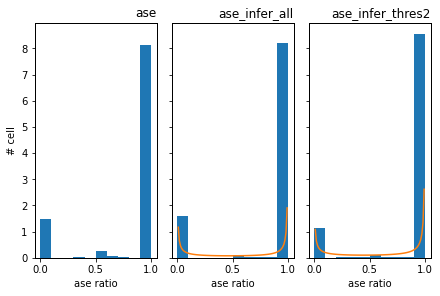

In [7]:
x = np.linspace(0, 1.0, 100)
a = ase_infer_stat['a_hat']
b = ase_infer_stat['b_hat']
r = stats.beta.pdf(x,a, b)

a2 = ase_infer_stat2['a_hat']
b2 = ase_infer_stat2['b_hat']
r2 = stats.beta.pdf(x,a2, b2)

fig,ax = plt.subplots(ncols=3,sharex=True,sharey=True,constrained_layout=True)
ax[0].hist(ase['ub_maternal']/(ase['ub_paternal']+ase['ub_maternal']).round(5),density=True)
ax[0].set_title('ase',loc='right')
ax[0].set_xlabel('ase ratio')
ax[0].set_ylabel('# cell')

ax[1].hist(ase_infer['maternal_infer']/(ase_infer['paternal_infer']+ase_infer['maternal_infer']).round(5),density=True)
ax[1].set_title('ase_infer_all',loc='right')
ax[1].set_xlabel('ase ratio')
ax[1].plot(x,r)

ax[2].hist(ase_infer2['maternal_infer']/(ase_infer2['paternal_infer']+ase_infer2['maternal_infer']).round(5),density=True)
ax[2].set_title('ase_infer_thres2',loc='right')
ax[2].set_xlabel('ase ratio')
ax[2].plot(x,r2)

In [8]:
ase_infer_stat

,gene,nref,nall,percent,a_hat,Ia_lb,Ia_ub,b_hat,Ib_lb,Ib_ub
0,ENSG00000064886,514,2476,0.207593,0.132249,0.068565,0.195932,0.025443,0.013575,0.037311


In [9]:
ase_infer_stat2

,gene,nref,nall,percent,a_hat,Ia_lb,Ia_ub,b_hat,Ib_lb,Ib_ub
0,ENSG00000064886,66,2476,0.026656,0.22774,-2.368668,2.824148,0.035236,-0.189237,0.259709


In [10]:
from lib.ase_reform_phased import *

ase_infer.columns = ['cb','gene','ub_maternal','ub_paternal','umi']
sparse_mat, allele_list, cb_list = process_phased(ase_infer)

cb_idx = pd.DataFrame(cb_list, columns=['cb'])
cb_idx.reset_index(inplace=True)
allele_idx = pd.DataFrame(allele_list, columns=['allele'])
allele_idx.reset_index(inplace=True)

In [11]:
from joblib import delayed,Parallel
from os import cpu_count
from lib.kpe import *

method='pb'
out_prefix='test'
ase_mat = sparse_mat.toarray()
data = Parallel(n_jobs=cpu_count())(delayed(est_vec)(vec,method) for i,vec in enumerate(ase_mat))

out_kpe_file = out_prefix + '_' + method + '.est'
cols = ['kon','koff','ksyn','n','mean','var']
out_index = allele_idx['allele'].tolist()
kpe = pd.DataFrame(data,columns=cols,index=out_index)
kpe.to_csv(out_kpe_file,float_format="%.5f")

ase_reform = pd.DataFrame(ase_mat, index=out_index)
out_ase_file = out_prefix + '.ase.reform'
ase_reform.to_csv(out_ase_file)

In [12]:
from scipy.stats import poisson, beta, power_divergence, chi2
from lib.evaluation import *

kpe.dropna(inplace=True)
n = kpe['n'].unique()

# simulate the expression with pb
cols = ['kon','koff','ksyn']
simulated_cols = [ 'sim_' + x for x in cols ]
simulated_data = Parallel(n_jobs=cpu_count())(delayed(pb_simulation)(row[cols],n) for i,row in kpe.iterrows())

# re-estimate the kp from the simulated profile
res_data = Parallel(n_jobs=cpu_count())(delayed(est_row)(row,method) for row in simulated_data)
kpe[simulated_cols] = res_data

# likelihood ratiotest
for i, (idx, row) in enumerate(kpe.iterrows()):
    sim_data = np.array(simulated_data[i])
    org_data = ase_reform.loc[idx].astype(np.float32).values

    sim_kp = row[simulated_cols].values
    org_kp = row[cols].values

    if np.sum(sim_data) == 0:
        kpe.loc[idx,'chisq_pval'] = np.nan
        kpe.loc[idx,'simlr_pval'] = np.nan
        continue

    chisq, p = GoF(sim_data, org_data)
    simlr = simLikelihoodRatioTest(sim_kp, sim_data, org_kp, org_data)

    kpe.loc[idx,'chisq_pval'] = p
    kpe.loc[idx,'simlr_pval'] = simlr

out_file = out_prefix + '.est.eval'
kpe.to_csv(out_file)

In [13]:
kpe[cols].head()
kpe[simulated_cols].head()

,sim_kon,sim_koff,sim_ksyn
ENSG00000064886-maternal_allele,2.060945,70.347839,61.815302
ENSG00000064886-paternal_allele,0.139265,9.814429,28.394707


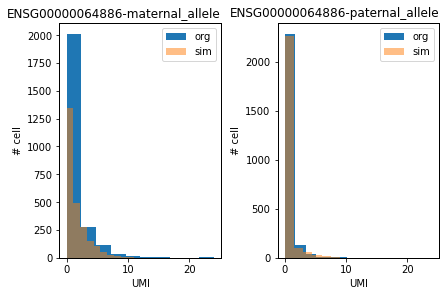

In [14]:
fig,ax = plt.subplots(ncols=2,sharex=True,constrained_layout=True)
for i, (idx, row) in enumerate(kpe.iterrows()):
    sim_data = np.array(simulated_data[i])
    org_data = ase_reform.loc[idx].astype(np.float32).values

    sim_kp = row[simulated_cols].values
    org_kp = row[cols].values
    ax[i].set_title(idx,loc='right')
    ax[i].set_xlabel('UMI')
    ax[i].set_ylabel('# cell')
    ax[i].hist(org_data,label='org')
    ax[i].hist(sim_data,label='sim',alpha=0.5)
    ax[i].legend()

In [17]:
from lib.variance import *
# simulate the expression with pb

out_file = out_prefix + '.est.var'

cols = ['kon','koff','ksyn']
data = Parallel(n_jobs=cpu_count())(\
delayed(fun)(ase_reform.loc[idx].values, row[cols].values, out_file) for idx,row in kpe.iterrows())

add_cols = ['kon_mean','koff_mean', 'ksyn_mean',\
            'kon_lower','kon_upper','koff_lower','koff_upper','ksyn_lower','ksyn_upper']

kpe[add_cols] = data

kpe.to_csv(out_file,float_format="%.5f")

In [18]:
print_cols = ['kon_mean','kon_lower','kon_upper',\
    'koff_mean','koff_lower','koff_upper',\
    'ksyn_mean','ksyn_lower','ksyn_upper']
kpe[print_cols].head()

,kon_mean,kon_lower,kon_upper,koff_mean,koff_lower,koff_upper,ksyn_mean,ksyn_lower,ksyn_upper
ENSG00000064886-maternal_allele,2.214994,2.116345,2.295295,588.771391,565.223146,612.035685,474.228354,454.345411,496.891052
ENSG00000064886-paternal_allele,0.164461,0.148868,0.181395,288.965233,254.988354,326.738824,668.891350,595.416630,745.596184


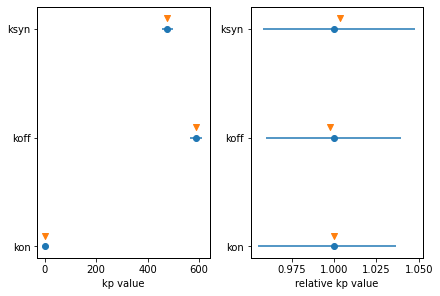

In [20]:
fig,ax = plt.subplots(constrained_layout=True, ncols=2)
allele = 'ENSG00000064886-maternal_allele'

y=np.arange(len(cols))
kp_org   = ['kon','koff', 'ksyn']
kp_mean  = ['kon_mean','koff_mean', 'ksyn_mean']
kp_error = ['kon_lower','koff_lower','ksyn_lower','kon_upper','koff_upper','ksyn_upper',]

x_org = kpe.loc[allele, kp_org].values.reshape((1,-1))
x = kpe.loc[allele, kp_mean].values.reshape((1,-1))
x_error = kpe.loc[allele, kp_error].values.reshape((2, -1))
x_error_reform = abs(x_error - x)

ax[0].errorbar(x.reshape(-1), y, xerr=x_error_reform,fmt='o')
ax[0].scatter(x_org.reshape(-1), y+0.1, marker='v', color='#ff7f0e')
ax[0].set_xlabel('kp value')
ax[0].set_yticks(y)
ax[0].set_yticklabels(['kon','koff','ksyn'])

ax[1].errorbar(np.ones(len(cols)), y, xerr=x_error_reform/x,fmt='o')
ax[1].scatter(x_org/x, y+0.1, marker='v', color='#ff7f0e')
ax[1].set_xlabel('relative kp value')
ax[1].set_yticks(y)
ax[1].set_yticklabels(['kon','koff','ksyn'])

plt.show()


In [34]:
def fun_compare(x,y):
    logx = np.log10(x)
    logy = np.log10(y)
    if logy > logx - 0.3 and logy < logx + 0.3: return 1
    else: return 0

#filter criterion
kpe_eval_in = '/home/bxj139/ASE/test.est.eval'
kpe_var_in = '/home/bxj139/ASE/test.est.var'

kpe_var  = pd.read_csv(kpe_var_in, header=0, index_col=0)
kpe_eval = pd.read_csv(kpe_eval_in, header=0, index_col=0)
ori_cols = ['kon','koff','ksyn']
sim_cols = ['sim_' + x for x in ori_cols ]

for i, (kp1,kp2) in enumerate(zip(ori_cols, sim_cols)):
    new_col = 'col' + str(i)
    kpe_eval[new_col] = kpe_eval_all.apply(lambda row: fun_compare(row[kp1],  row[kp2]),  axis=1)
kpe_eval['col']  = kpe_eval.apply(lambda row: row['col0']*row['col1']*row['col2'], axis=1)
kpe_eval['consist']  = (kpe_eval['col']==1)& ((kpe_eval['chisq_pval'] > 0.05)|(kpe_eval['simlr_pval'] > 0.05))
kpe_eval = kpe_eval[kpe_eval['consist']==1]

for kp in ori_cols:
    mean = kp + '_mean'
    lower = kp + '_lower'
    upper = kp + '_upper'
    ci = kp + '_ci' 

    select = (kpe_var[mean] > kpe_var[lower]) & (kpe_var[mean] < kpe_var[upper])
    kpe_var.loc[select,ci] = ( kpe_var.loc[select,upper] - kpe_var.loc[select,lower] )/ kpe_var.loc[select,mean]

kpe_var[ci] = kpe_var[ci].transform(np.log2)
ci_cols = [ x + '_ci' for x in ori_cols ]
select = (kpe_var[ci_cols] <= 1) 
stat = np.sum(select, axis=1)
kpe_var_filter = kpe_var[stat > 2]

kpe_union = pd.merge(kpe_eval, kpe_var_filter, how='outer',suffixes=('_eval',''), left_index=True, right_index=True)
kpe['pass'] = 0
kpe.loc[kpe_union.index.tolist(),'pass'] = 1

kpe

,kon,koff,ksyn,n,mean,var,sim_kon,sim_koff,sim_ksyn,chisq_pval,...,kon_mean,koff_mean,ksyn_mean,kon_lower,kon_upper,koff_lower,koff_upper,ksyn_lower,ksyn_upper,pass
ENSG00000064886-maternal_allele,2.215547,587.543887,475.919643,2476,1.787561,4.654385,2.060945,70.347839,61.815302,0.246965,...,2.214994,588.771391,474.228354,2.116345,2.295295,565.223146,612.035685,454.345411,496.891052,1
ENSG00000064886-paternal_allele,0.163688,289.086859,659.661049,2476,0.373183,1.371236,0.139265,9.814429,28.394707,NaN,...,0.164461,288.965233,668.891350,0.148868,0.181395,254.988354,326.738824,595.416630,745.596184,1


In [36]:
ase_profile='/home/bxj139/ASE/test_thres1.ase.record'
ase_eval = pd.read_csv(ase_profile, header=0)
ase_eval['a_qc'] = ase_eval.apply(lambda x: (x.Ia_lb > 0) & (x.Ia_ub > 0) ,axis=1)
ase_eval['b_qc'] = ase_eval.apply(lambda x: (x.Ib_lb > 0) & (x.Ib_ub > 0),axis=1)
ase_eval['qc']   = ase_eval.apply(lambda x: x.a_qc & x.b_qc,axis=1)
ase_eval

,gene,nref,nall,percent,a_hat,Ia_lb,Ia_ub,b_hat,Ib_lb,Ib_ub,a_qc,b_qc,qc
0,ENSG00000064886,514,2476,0.207593,0.132249,0.068565,0.195932,0.025443,0.013575,0.037311,True,True,True


In [37]:
kpe[['gene','allele']] = kpe.index.to_series().str.split('-', n=1, expand=True)
filter_gene = ase_eval.loc[ase_eval['qc']==True,'gene']
kpe_filter = kpe.loc[kpe['gene'].isin(filter_gene)]
kpe_filter

,kon,koff,ksyn,n,mean,var,sim_kon,sim_koff,sim_ksyn,chisq_pval,...,ksyn_mean,kon_lower,kon_upper,koff_lower,koff_upper,ksyn_lower,ksyn_upper,pass,gene,allele
ENSG00000064886-maternal_allele,2.215547,587.543887,475.919643,2476,1.787561,4.654385,2.060945,70.347839,61.815302,0.246965,...,474.228354,2.116345,2.295295,565.223146,612.035685,454.345411,496.891052,1,ENSG00000064886,maternal_allele
ENSG00000064886-paternal_allele,0.163688,289.086859,659.661049,2476,0.373183,1.371236,0.139265,9.814429,28.394707,NaN,...,668.891350,0.148868,0.181395,254.988354,326.738824,595.416630,745.596184,1,ENSG00000064886,paternal_allele
